# 6장 - 학습 관련 기술들
신경망 학습의 핵심 개념들
1. 가중치 매개변수의 최적값을 탐색하는 최적화 방법
2. 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등
3. 오버피팅의 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법
4. 배치 정규화
--------------------
--------------------

신경망 학습의 목적: 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 일 = 매개변수의 최적값을 찾는 문제 = 최적화의 문제<br>
확률적 경사 하강법(SGD)은 매개변수의 기울기를 구해 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇 번이고 반복해서 점점 최적의 값에 다가가는 것<br>

In [1]:
# 확률적 경사 하강법 구현
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD의 단점: 비등방성함수(방향에 따라 성질이 달라지는 함수)에서는 탐색 경로가 비효율적임

In [2]:
import numpy as np

# 모멘텀 구현
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

            for key in params.keys():
                self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
                params[key] += self.v[key]

AdaGrad: 학습률을 개별 매개변수에 적응적으로 조정하면서 학습을 진행

In [3]:
# AdaGrad 구현
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

Adam: 모멘텀 + AdaGrad의 융합으로, 하이퍼파라미터의 '편향 보정'이 진행된다.

---------------------

가중치 감소: 오버피팅을 억제해 범용 성능을 높이는 테크닉(가중치 매개변수의 값이 작아지도록 학습하는 방법)

In [4]:
# 가중치의 초깃값에 따른 은닉층 활성화값(활성화 함수의 출력 데이터) 변화 관찰
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x =activations[i-1]

    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

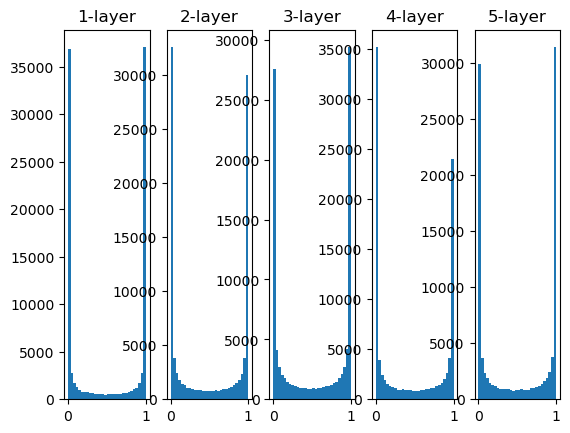

In [6]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show() # 가중치를 표준편차가 1인 정규분포로 초기화할 때의 각 층의 활성화값 분포

기울기 소실: 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다.

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x =activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

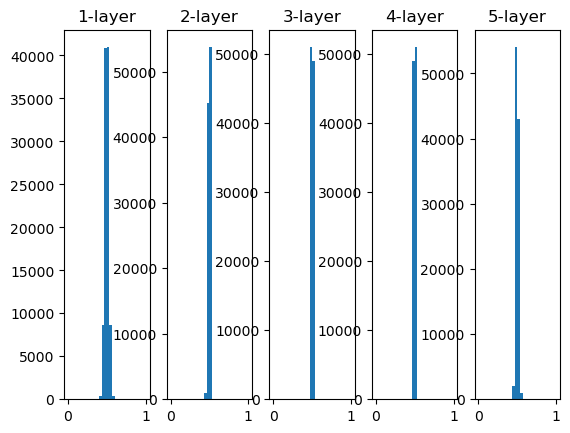

In [8]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show() # 가중치를 표준편차가 0.01인 정규분포로 초기화할 때의 각 층의 활성화값 분포

다수의 뉴런이 거의 같은 값을 출력 중이므로 뉴런을 여러 개 둔 의미가 없어졌다.<br>
활성화값들이 치우치면 **표현력을 제한**한다는 관점에서 문제가 된다.

--------------------

Xavier 초깃값: 초깃값의 표준편차가 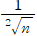이 되도록 설정(n은 앞 층의 노드 수)

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x =activations[i-1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

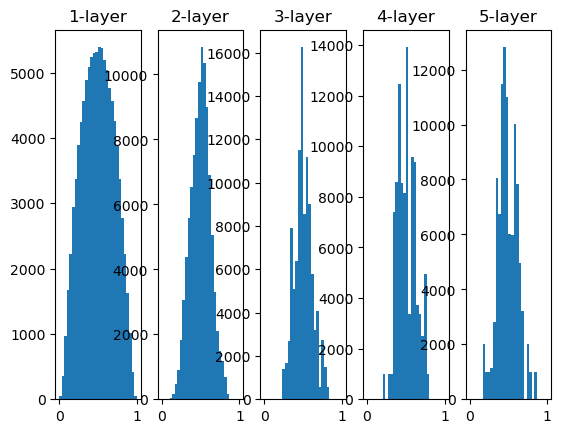

In [10]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show() # 가중치를 표준편차가 Xavier인 정규분포로 초기화할 때의 각 층의 활성화값 분포

Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 한다.<br>
ReLU를 이용할 때에는 ReLU에 특화된 초깃값(***He 초깃값***)을 사용해야 한다.<br>
He 초깃값: 앞 계층의 노드가 n개일 때, 표준편차가 인 정규분포를 사용한다.<br>
ReLU함수는 음의 영역이 0이기 때문에 더 넓게 분포시키기 위해 2배의 계수가 필요하기 때문.

-------------------
배치 정규화: 각 층이 활성화를 적당히 퍼뜨리도록 강제하자는 아이디어에서 출발<br>
1. 학습을 빨리 진행할 수 있다(학습 속도 개선)
2. 초깃값에 크게 의존하지 않는다(골치아픈 초깃값 선택 문제에서 해방)
3. 오버피팅을 억제한다(드롭아웃 등의 필요성 감소)

------------------------------------
오버피팅: 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태<br>
<br>
주로 다음의 경우에 나타남
1. 매개변수가 많고 표현력이 높은 모델
2. 훈련 데이터가 적음

가중치 감소: 오버피팅 억제를 위해 많이 쓰이는 방법.<br>
학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부여하는 방법.

신경망 모델이 복잡해지면 가중치 감소만으로는 오버피팅에 대응하기 어려움

---------------------
드롭아웃 기법: 뉴런을 임의로 삭제하면서 학습하는 방법<br>
훈련 때 은닉층의 뉴런을 무작위로 골라 삭제한다.<br>
훈련 때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달한다.<br>
(단, 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력)

In [12]:
# 드롭아웃 구현
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

--------------------------------------------
데이터 분류
1. 훈련 데이터: 매개변수 학습
2. 검증 데이터: 하이퍼파라미터 성능 평가
3. 시험 데이터: 신경망의 범용 성능 평가